# AML Exam (Skin disease image classification)

# 1. Importing Libraries / Defining Global Functions

In [1]:
import random # Generating Random Numbers
import os # Loading images
import shutil # Copying and moving images
import numpy as np # Handling big data
import cv2 # Image loading and augmenting
from matplotlib import pyplot as plt # Visualizing Data
import pickle # Saving/loading models
from sklearn.utils import shuffle as ashuffle

# Remove unneccesary warning messages
import warnings
warnings.filterwarnings("ignore")

# Gathering model results
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# .DS_Store and .ipynb_checkpoints was generated automatically
# throughout this project, and this would mess up our loops when
# loading images, this function makes sure the loaded list deletes
# theese files to prevent problems.
def remove_unwanted_folders(folder):
    if ".DS_Store" in folder:
        folder.remove(".DS_Store")
    if ".ipynb_checkpoints" in folder:
        folder.remove(".ipynb_checkpoints")

# 2. Data Processor Class

In [2]:
class DataProcessor:
    __doc__ = "Class that assists with different data processing actions."
    
    def __init__(self, original_data_path, target_folder):
        self.original_path = original_data_path
        self.classes = os.listdir(self.original_path)
        remove_unwanted_folders(self.classes)
        
        self.target_path = target_folder
        self.target_folder = os.listdir(self.target_path)
        remove_unwanted_folders(self.target_folder)
        
        print("Data Processor successfully created!")
    
    def generate_xy(self, class_folder, shuffle=True):
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Gathering Training Data
        for class_label in self.classes:
            images = os.listdir(os.path.join(class_folder, class_label))
            for current_image in images:
                # Load every image in current class folder as cv2 image
                current_image_full_path = os.path.join(class_folder, class_label, current_image)
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))

                # Adds current image to list, flattened.
                temp_x.append(current_image.flatten())
                temp_y.append(class_label)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x), -1)/255
        temp_y = np.array(temp_y)
        
        if shuffle == True:
            temp_x , temp_y = ashuffle(temp_x, temp_y)
            
        print(f"{len(temp_x)} images within {len(self.classes)} classes successfully loaded!")
        return temp_x, temp_y
    generate_xy.__doc__ = '''This function will generate array of X and array of Y data from chosen folder.
                              Folder has to contain all classes.
                              
                              Parameters:
                              
                              - class_folder: path to folder containing all classes.
                              
                              - Shuffle: Wheter to shuffle data before returning arrays.
                                         Defaults is True.
                                         
                              Example:
                              train_x, train_y = generate_xy("./train/")'''
    
    def generate_xy_by_axis(self, class_folder, shuffle=True, axis=0):
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Gathering Training Data
        for class_label in self.classes:
            images = os.listdir(os.path.join(class_folder, class_label))
            for current_image in images:
                # Load every image in current class folder as cv2 image
                current_image_full_path = os.path.join(class_folder, class_label, current_image)
                current_image = cv2.imread(current_image_full_path)
                #current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
                current_image = cv2.resize(current_image,(224,224))
                
                # Adds current image to list, flattened.
                temp_x.append((np.sum(current_image, axis=axis)/224)/255)
                temp_y.append(class_label)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x),-1)
        temp_y = np.array(temp_y)
        
        if shuffle == True:
            temp_x , temp_y = ashuffle(temp_x, temp_y)
            
        print(f"{len(temp_x)} images within {len(self.classes)} classes successfully loaded!")
        return temp_x, temp_y
        generate_xy_by_axis.__doc__ = '''his function will generate array of X and array of Y data from chosen folder.
                              Folder has to contain all classes. The image pixels will be summed by row or coloumn, then
                              divided by number of rows or coloumns to get the average by that axis. This can be plotted
                              on a graph to get interesting insights in the data.
                              
                              Parameters:
                              
                              - class_folder: path to folder containing all classes.
                              
                              - Shuffle: Wheter to shuffle data before returning arrays.
                                         Defaults is True.
                                         
                              Example:
                              train_x, train_y = generate_xy_by_axis("./train/")'''
    
    
    def generate_folders(self):
        # Function for creating folders.
        def create_folders(target_path):
            # Define folders to generate
            folders = ["train","val","test"]

            for folder in folders:
                # Create new folders with the name of train, val, or test
                os.mkdir(os.path.join(self.target_path, folder))

                # For each folder, create new folder with each class labels (diseases)
                for class_label in self.classes:
                    os.mkdir(os.path.join(self.target_path, folder, class_label))
            print("Train, Val and test folders created!")
        
        target_folder = os.listdir(self.target_path)
        
        # Check if the Target folder is empty or contains "temp"
        if (target_folder == ['temp']) or (target_folder == []):
            create_folders(self.target_path)
        else:
            # If the target folder is not empty
            print("Save folder not empty!")
            u_input = input("Do you wish to overwrite? (y/n)")

            # If they decide to overwrite, remove train, val, test folders
            if u_input == "y":
                for folder in target_folder:
                    # Keep temp folder if it exists.
                    if folder == "temp":
                        pass
                    else:
                        shutil.rmtree(os.path.join(self.target_path, folder))

                # Recreate folders
                create_folders(self.target_path)
            else:
                # If they do not decide to overwrite:
                print("Please delete folders and try again.")
    generate_folders.__doc__ = '''The generate_folders() function will generate train, validation and test folders.
                                  Theese folders will be populated with every class found in the original dataset.
                                  If the folder is not empty it will prompt to overwrite current train, val and test folders.
                                  The "temp" folder generated with augment_images will not be removed when overwriting.'''
            
    
    def move_images(self):
        total_train_images = 0
        total_val_images = 0
        total_test_images = 0
        target_folder = os.listdir(self.target_path)
        if "train" in target_folder and "val" in target_folder and "train" in target_folder:
            for class_label in self.classes:
                # Get all images inside each corresponding disease folder
                images = os.listdir(os.path.join(self.target_path,"temp",class_label))
                remove_unwanted_folders(images)
                images = np.array(images)
                np.random.shuffle(images)

            # Calculating Train, Validation and Test image count
                train_partition = int(len(images)*.7)
                total_train_images += train_partition
                
                validation_partition = int(len(images)*.2)
                total_val_images += validation_partition
                
                test_partition = int(len(images)*.1)
                total_test_images += test_partition

            # Empty lists to store all numbers in range into a list.
                train_partition_indexes = []
                validation_partition_indexes = []
                test_partition_indexes = []

            # Array of Train images from partition.
                for x in range(0,train_partition):
                    train_partition_indexes.append(x)
                train_image_array = np.take(images,train_partition_indexes)

            # Array of Validation images from partition.
                for x in range(train_partition, train_partition + validation_partition):
                    validation_partition_indexes.append(x)
                validation_image_array = np.take(images, validation_partition_indexes)

            # Array of Test images from partition.
                for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
                    test_partition_indexes.append(x)
                test_image_array = np.take(images, test_partition_indexes)


            # Moving images to their respective train, validation and test folders
                # • Train Images
                for current_image in train_image_array:
                    current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"train",class_label, current_image))

                # • Validation Images
                for current_image in validation_image_array:
                    current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"val",class_label, current_image))

                # • Test Images
                for current_image in test_image_array:
                    current_image_full_path = os.path.join(self.target_path, "temp", class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"test",class_label,current_image))
            print(f"{total_train_images} images moved into train.")
            print(f"{total_val_images} images moved into val.")
            print(f"{total_test_images} images moved into test.")
            shutil.rmtree(os.path.join(self.target_path, "temp"))
        else:
            print("Folder is missing train, val, and test folders, please run generate_folders() first.")
    move_images.__doc__ = '''The move_images function will transfer all augmented data into train, val and test
                             from temp which is generated using the augment_images() function.'''
            
        
    
    def augment_images(self, copies=2, brightness=[-60,90], contrast=[0.5,1.7], zoom=[20,40]):
        # Defining Functions used for augmentation
        def save_Augmented_Image(save_path,img):
            cv2.imwrite(save_path,img)

        def generate_r_value(min_value, max_value):
            if (type(min_value) == int) or (type(max_value) == int):
                rand_n = random.randint(min_value, max_value)
            if (type(min_value) == float) or (type(max_value) == float):
                rand_n = random.uniform(min_value, max_value)
            return rand_n
    
        # Specify Parameters
        brightness_min = brightness[0]
        brightness_max = brightness[1]
        contrast_min = contrast[0]
        contrast_max = contrast[1]
        zoom_min = zoom[0]
        zoom_max = zoom[1]
        
        # Create temporary folder
        if "temp" in (os.listdir(self.target_path)):
            print("temp was already in target folder, overwriting.")
            shutil.rmtree(os.path.join(self.target_path, "temp"))
        os.mkdir(os.path.join(self.target_path, "temp"))
        
        id_counter = 0
        original_counter = 0
        for class_label in self.classes: # Looping over all disease folders
            os.mkdir(os.path.join(self.target_path, "temp", class_label))
            self.target_folder = os.listdir(self.target_path)
            # Get all images inside of current disease folder

            images = os.listdir(os.path.join(self.original_path, class_label))

            # Loading each image in folder
            for current_image in images:
                # Track amount of original images
                original_counter += 1
                # Get full path of current image
                current_image_full_path = os.path.join(self.original_path, class_label, current_image)

                # ----- Augment Orginal ----
                id_counter +=1
                current_image_cv2 = cv2.imread(current_image_full_path)                              
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"o_{id_counter}_"+current_image), current_image_cv2)
                
                # Adjust Brightness original
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast original
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(current_image_cv2, alpha=generate_r_value(contrast_min, contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_c_{id_counter}_"+current_image),contrast_image)
                # Zoom original
                for x in range(copies):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = current_image_cv2[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (current_image_cv2.shape[1], current_image_cv2.shape[0]), interpolation=cv2.INTER_CUBIC)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"z_{id_counter}_"+current_image), zoomed_image)


                # ---- FLip Horizontal ----
                # Flip Horizontal
                id_counter +=1
                horizontal_flip_image = cv2.flip(current_image_cv2,1)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hF_{id_counter}_"+current_image),horizontal_flip_image)

                # Adjust Brightness horizontal
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast horizontal
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=generate_r_value(contrast_min, contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_c_{id_counter}_"+current_image),contrast_image)
                # Zoom horizontal flip
                for x in range(copies):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = horizontal_flip_image[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (horizontal_flip_image.shape[1], horizontal_flip_image.shape[0]), interpolation=cv2.INTER_CUBIC)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"z_{id_counter}_"+current_image), zoomed_image)


                # ---- FLip Vertical ---
                # Flip Vertical
                id_counter +=1
                vertical_flip_image = cv2.flip(current_image_cv2,0)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vF_{id_counter}_"+current_image),vertical_flip_image)
                
                # Adjust Brightness vertical
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(vertical_flip_image, alpha=1, beta=generate_r_value(brightness_min, brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast vertical
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(vertical_flip_image, alpha=generate_r_value(contrast_min , contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_c_{id_counter}_"+current_image),contrast_image)
                # Zoom vertical flip
                for x in range(copies):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = vertical_flip_image[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (vertical_flip_image.shape[1], vertical_flip_image.shape[0]), interpolation=cv2.INTER_CUBIC)

        print(f"{id_counter-original_counter} augmented images created from {original_counter} original images. Total: {id_counter} images.")
        u_input = input("Do you wish to move theese into train, val, test using the move_images() function? (y/n)")
        if u_input == "y":
            self.move_images()
    augment_images.__doc__ = '''The augment_images function will generate augmented images from the original images.
    
                                 Parameters:
                                 
                                 - copies:      how many brightness, contrast and zoom images to create from original, vertical flipped 
                                                and horizontal flipped image. Default is 2.

                                 - brightness:  list of min and max brightness variation that will be applied to image.
                                                Default for brightness is [-60,90]

                                 - contrast:    list of min and max contrast variation that will be applied to image.
                                                Default for contrast is [0.5,1.7]

                                 - zoom:        List of min and max zoom variation that will be applied to image.
                                                Default for zoom is [0.5,1.7]'''

In [ ]:
data_p = DataProcessor("./Data/original_data/","./Data/test/")

In [ ]:
data_p.augment_images(copies=1)

In [ ]:
data_p.generate_folders()

In [ ]:
data_p.move_images()

In [ ]:
train_x , train_y = data_p.generate_xy_by_axis("./Data/test/train/",axis=0)

In [192]:
del(data_p)

# 3. K-Nearest Neighbour (KNN)

## • Importing Libraries

In [3]:
from sklearn.neighbors import KNeighborsClassifier

## • Load processed data

In [23]:
knn_dataprocessor = DataProcessor("./Data/original_data/","./Data/test/")

Data Processor successfully created!


In [24]:
knn_dataprocessor.generate_folders()

Train, Val and test folders created!


In [25]:
knn_dataprocessor.augment_images(copies=1, brightness=[-80,90], contrast=[0.4,1.9],zoom=[20,60])

12749 augmented images created from 1159 original images. Total: 13908 images.


Do you wish to move theese into train, val, test using the move_images() function? (y/n) y


8923 images moved into train.
2548 images moved into val.
1273 images moved into test.


In [25]:
knn_dataprocessor.move_images()

2432 images moved into train.
693 images moved into val.
344 images moved into test.


In [87]:
train_x, train_y = knn_dataprocessor.generate_xy_by_axis("./Data/test/train",axis=0)
test_x, test_y = knn_dataprocessor.generate_xy_by_axis("./Data/test/test",axis=0)

15411 images within 8 classes successfully loaded!
2199 images within 8 classes successfully loaded!


In [26]:
train_x, train_y = knn_dataprocessor.generate_xy("./Data/test/train")
test_x, test_y = knn_dataprocessor.generate_xy("./Data/test/test")

8923 images within 8 classes successfully loaded!
1273 images within 8 classes successfully loaded!


## • Visualizing Loaded Data

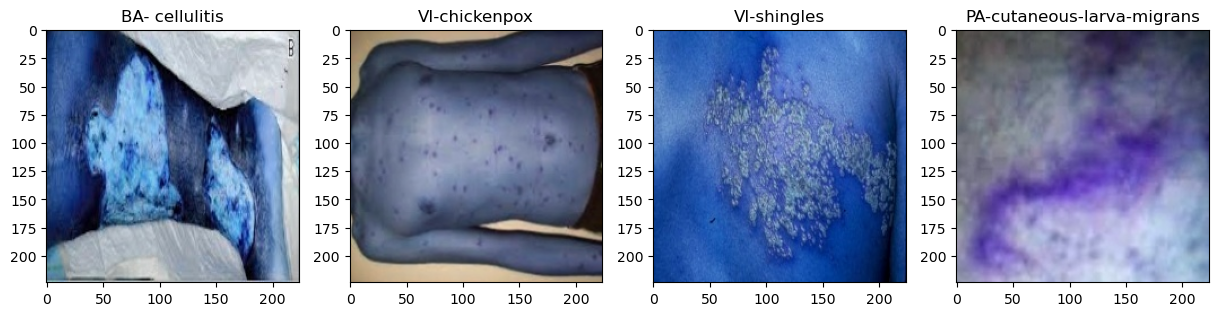

In [27]:
# Plotting Sample of the dataset
# If the shape is greater than 225, this means they are images and not summed coloumn dataset.
if train_x.shape[1] > 700:
    plot_images = train_x.reshape((len(train_x),224,224,3))
    fig, ax = plt.subplots(ncols=4, figsize=(15,15))
    # Looping over 4 images and plotting them
    for index, image in enumerate(train_x[:4]):
        ax[index].imshow(plot_images[index])
        ax[index].title.set_text(train_y[index])

else:
    # Plotting Sample of the dataset
    fig, ax = plt.subplots(ncols=4, figsize=(17,4))
    # Looping over 4 images and plotting them
    for index, image in enumerate(train_x[0:4]):
        ax[index].plot(train_x[index])
        ax[index].title.set_text(train_y[index])

## • Define Model

In [28]:
knn = KNeighborsClassifier()

## • Train Model

In [29]:
%%time
knn.fit(train_x, train_y)

CPU times: total: 19.8 s
Wall time: 41.3 s


KNeighborsClassifier()

## • Gathering Model Results

In [30]:
%%time
# __min __s (200 images) on Macbook Air m2
# 14min 18s (200 images) on desktop
result_image_count = 1000

y_pred_train = knn.predict(train_x[:result_image_count])
y_pred_test = knn.predict(test_x[:result_image_count])

CPU times: total: 3min 50s
Wall time: 1min 16s


### • Accuracy Score

In [31]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.81
Test accuracy:  0.601


### • Classification Report

In [32]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.83      0.61      0.70       154
               BA-impetigo       0.73      0.42      0.54        78
           FU-athlete-foot       0.97      0.69      0.81       135
            FU-nail-fungus       0.67      0.34      0.45       137
               FU-ringworm       0.29      0.75      0.42        96
PA-cutaneous-larva-migrans       0.62      0.49      0.55       112
             VI-chickenpox       0.71      0.78      0.75       147
               VI-shingles       0.51      0.65      0.57       141

                  accuracy                           0.60      1000
                 macro avg       0.67      0.59      0.60      1000
              weighted avg       0.68      0.60      0.61      1000



## • Load model

In [5]:
model_path = "../../Saved_Models/knn.h5"
rfc = pickle.load(open(model_path, 'rb'))

CPU times: total: 2.53 s
Wall time: 10.4 s


## • Export model as pickle

In [19]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/knn_61.h5"
pickle.dump(k_nn, open(save_model, 'wb'))

CPU times: total: 1min 8s
Wall time: 4min 15s


## • Predict with model

Actual Class: FU-ringworm
Predicted Class: FU-ringworm
   --- Correctly Classified ---   
CPU times: total: 6.77 s
Wall time: 1.39 s


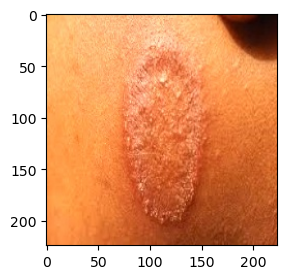

In [37]:
%%time
# Load new image to predict
image_path = './Data/test/val/FU-ringworm/hf_c_8347_95_FU-ringworm (29).jpg'
actual_class = image_path.split("/")[4]

predict_image = cv2.imread(image_path)

if train_x.shape[1] > 700:
    predict_image = cv2.resize(predict_image, (224,224))
    pred = cv2.resize(predict_image, (224,224))
    pred = np.array(pred.flatten()).reshape(1,-1)/255
    
    # Plot actual image and the summed axis plot
    RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(ncols=1, figsize=(8,3))
    ax.imshow(RGB_image)

    # Get prediction
    prediction = knn.predict(pred.reshape(1,-1))

else:
    # Load new image to predict
    predict_image = cv2.resize(predict_image, (224,224))
    predict_image = ((np.sum(predict_image, axis=0)/224)/255).flatten()
    prediction = np.expand_dims(predict_image,axis=0)

    # Plot image in RGB
    RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # For display
    fig, ax = plt.subplots(ncols=2, figsize=(9,4))
    ax[0].plot(predict_image)    
    ax[1].imshow(RGB_image)

    # Get prediction
    prediction = knn.predict(prediction)

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {prediction[0]}")

if prediction == actual_class:
    print("   --- Correctly Classified ---   ")
else:
    print("   --- Incorrectly Classified ---   ")

# 4. Convolutional Neural Network (CNN)

## • Importing Tensorflow libraries for CNN model

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

## • Loading data with tensorflow

In [142]:
train = tf.keras.utils.image_dataset_from_directory("./Data/test/train/",image_size=(224,224))
val = tf.keras.utils.image_dataset_from_directory("./Data/test/val/", image_size=(224,224))

Found 8906 files belonging to 8 classes.
Found 2545 files belonging to 8 classes.


## • Transforming from regular 0-255 values to 0-1 values

In [143]:
train = train.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))

## • Defining Model Structure

In [183]:
cnn = Sequential()

In [190]:
del(cnn)

In [53]:
# loss: 0.7463 - accuracy: 0.7179 - val_loss: 0.7083 - val_accuracy: 0.8028 (5 epochs) maybe try few more.
cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(64, activation = "relu"))
#cnn.add(Dense(512, activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(Dense(8, activation = 'softmax'))
# id = 1

In [126]:
# loss: 0.6205 - accuracy: 0.7823 - val_loss: 0.6776 - val_accuracy: 0.8263 (5 epochs) try more
cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(128, activation = "relu"))
#cnn.add(Dense(512, activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(Dense(8, activation = 'softmax'))
# id = 2

In [ ]:
# loss: 0.1639 - accuracy: 0.9488 - val_loss: 0.5231 - val_accuracy: 0.8888 (7 epochs)
cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(16, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(128, activation = "relu"))
#cnn.add(Dense(512, activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(Dense(8, activation = 'softmax'))
# id = 3

In [184]:
# TEST THIS 5 epoch
cnn.add(Conv2D(64, 3, activation = "relu", padding = 'same', input_shape = (224, 224, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, 3, activation = "relu", padding = 'same'))
cnn.add(MaxPooling2D())

cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(128, activation = "relu"))
cnn.add(Dropout(0.15))

cnn.add(Dense(8, activation = 'softmax'))
# id = 4

In [ ]:
cnn.summary()

## • Compiling and training model

In [186]:
cnn.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [187]:
# Logging results in logs folder
logdir='logs'

In [188]:
# Allow tensorflow to log data
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
%%time
# __min __s on Macbook Air m2
# 28min 47s on desktop
# Saving stats in hist and fitting model.
hist = cnn.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

## • Results

### • Plotting Training Statistics

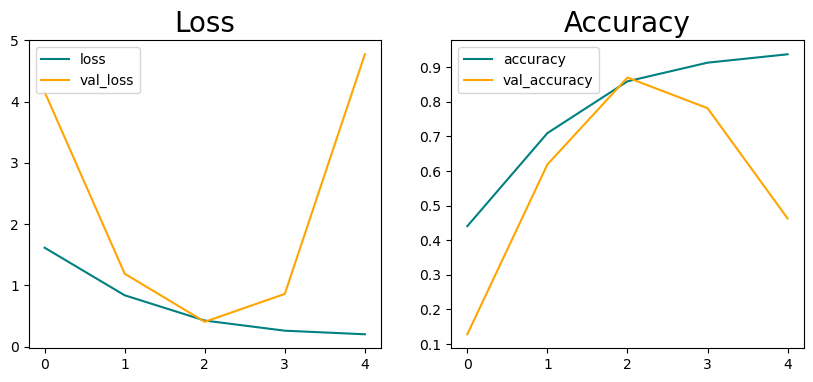

In [179]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend(loc="upper left")

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend(loc="upper left")
plt.show()

## • Load model

In [ ]:
# Model saved in Saved_Models folder in the desktop
cnn = tf.keras.models.load_model('../../Saved_Models/CNN_079.h5')

## • Export model as pickle

In [140]:
# Save model to Saved_Models folder in the desktop
cnn.save(os.path.join("../../Saved_Models","CNN_id_3.h5"))

## • Model Prediction

#### • Loading unseen image for prediction

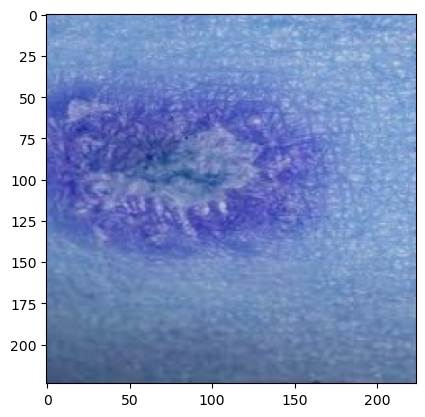

In [180]:
pred_image = cv2.imread('./Data/test/test/FU-ringworm/vf_b_8170_81_FU-ringworm (6).jpeg')
resize = tf.image.resize(pred_image, (224,224))
plt.imshow(resize.numpy().astype(int))

#### • Mapping Classes to indexes

In [103]:
class_map = {
    0: 'BA- cellulitis',
    1: 'BA-impetigo',
    2: 'FU-athlete-foot',
    3: 'FU-nail-fungus',
    4: 'FU-ringworm',
    5: 'PA-cutaneous-larva-migrans',
    6: 'VI-chickenpox',
    7: 'VI-shingles'}

#### • Resizing and prediction

In [181]:
# Resizing image from 0-255 to 0-1
pred_image = resize/255

# Expading dimension for it to fit the model
yhat = cnn.predict(np.expand_dims(pred_image, 0))

# Printing prediction values
print(yhat)

# Finding prediction with highest value
print(f"{class_map[np.argmax(yhat)]}")

1/1 [==============================] - 0s 99ms/step
[[9.9999738e-01 6.5567641e-13 7.2972123e-12 2.6356697e-06 1.5744671e-13
  4.1285149e-09 2.3116875e-11 1.8763931e-12]]
BA- cellulitis


# 5. Support Vector Machine (SVM)

## • Importing Libraries

In [128]:
from sklearn.svm import SVC

## • Loading Data

In [19]:
# Create DataProcessor object
svc_dataprocessor = DataProcessor("./Data/original_data/","./Data/test/")

Data Processor successfully created!


In [20]:
svc_dataprocessor.generate_folders()

Save folder not empty!


Do you wish to overwrite? (y/n) y


Train, Val and test folders created!


In [21]:
svc_dataprocessor.augment_images(copies=0)

2318 augmented images created from 1159 original images. Total: 3477 images.


Do you wish to move theese into train, val, test using the move_images() function? (y/n) y


2432 images moved into train.
693 images moved into val.
344 images moved into test.


In [350]:
# Generating Data from sum of axis
train_x ,train_y = svc_dataprocessor.generate_xy_by_axis("./Data/test/train/", shuffle=True, axis=1)
test_x ,test_y = svc_dataprocessor.generate_xy_by_axis("./Data/test/test", shuffle=True, axis=1)

15411 images within 8 classes successfully loaded!
2199 images within 8 classes successfully loaded!


In [59]:
# Generating Data from whole image
train_x ,train_y = svc_dataprocessor.generate_xy("./Data/original_data/")
test_x ,test_y = svc_dataprocessor.generate_xy("./Data/original_data/")

1159 images within 8 classes successfully loaded!


## • Visualizing Loaded Data

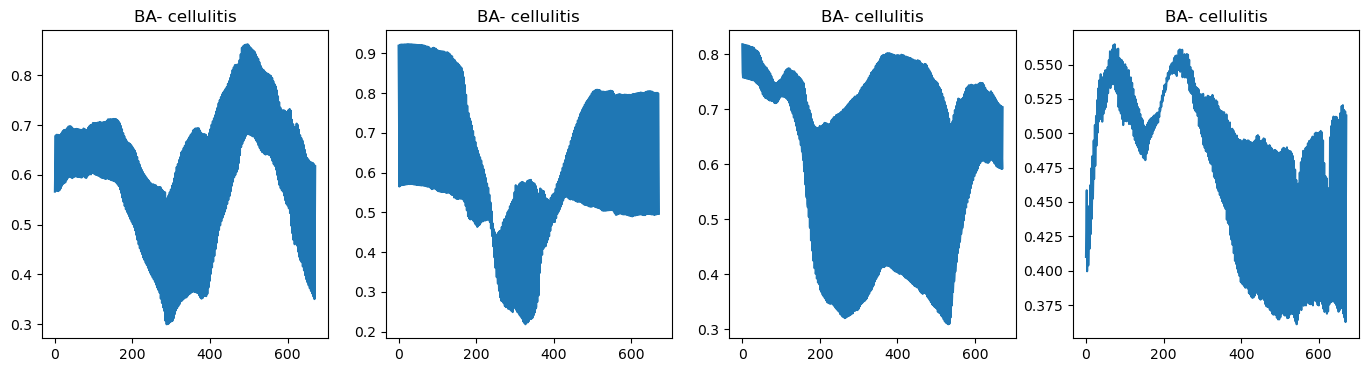

In [16]:
# Plotting Sample of the dataset
# If the shape is greater than 225, this means they are images and not summed coloumn dataset.
if train_x.shape[1] > 700:
    plot_images = train_x.reshape((len(train_x),224,224,3))
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    print(train_x.shape)
    # Looping over 4 images and plotting them
    for index, image in enumerate(train_x[:4]):
        ax[index].imshow(plot_images[index])
        ax[index].title.set_text(train_y[index])

else:
    # Plotting Sample of the dataset
    fig, ax = plt.subplots(ncols=4, figsize=(17,4))
    # Looping over 4 images and plotting them
    for index, image in enumerate(train_x[0:4]):
        ax[index].plot(train_x[index])
        ax[index].title.set_text(train_y[index])

## • Training Support Vector Classifier (SVC)

In [352]:
%%time
# __min __s on Macbook Air m2
# 25min 36s on desktop
svc = SVC(kernel="rbf")
svc.fit(train_x,train_y)

CPU times: user 1min 29s, sys: 413 ms, total: 1min 30s
Wall time: 1min 30s


SVC()

## • Gathering Model Results

In [353]:
%%time
# __min __s (200 images) on Macbook Air m2
# 14min 18s (200 images) on desktop
result_image_count = 5000

y_pred_train = svc.predict(train_x[:result_image_count])
y_pred_test = svc.predict(test_x[:result_image_count])

CPU times: user 43.9 s, sys: 101 ms, total: 44 s
Wall time: 44 s


### • Accuracy Score

In [354]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.5298
Test accuracy:  0.4965893587994543


### • Classification Report

In [345]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.49      0.56      0.52       323
               BA-impetigo       0.63      0.29      0.40       190
           FU-athlete-foot       0.64      0.45      0.53       296
            FU-nail-fungus       0.52      0.46      0.49       307
               FU-ringworm       0.62      0.30      0.40       214
PA-cutaneous-larva-migrans       0.65      0.34      0.45       237
             VI-chickenpox       0.44      0.74      0.55       323
               VI-shingles       0.38      0.61      0.47       309

                  accuracy                           0.49      2199
                 macro avg       0.55      0.47      0.48      2199
              weighted avg       0.53      0.49      0.48      2199



## • Load model

In [257]:
model_path = "../../Saved_Models/svc_rbf.h5"
svc = pickle.load(open(model_path, 'rb'))

## • Export model as pickle

In [72]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/SVC_large_augmented.h5"
pickle.dump(svc, open(save_model, 'wb'))

## • Predict with model

Actual Class: FU-athlete-foot
Predicted Class: VI-chickenpox
   --- Incorrectly Classified ---   


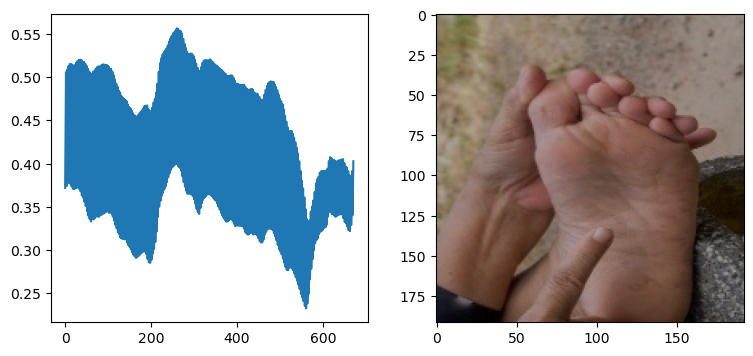

In [349]:
%%time
# Load new image to predict
image_path = './Data/test/val/PA-cutaneous-larva-migrans/o_b_14891_107_PA-cutaneous-larva-migrans (1).jpeg'
actual_class = image_path.split("/")[4]

predict_image = cv2.imread(image_path)

if train_x.shape[1] > 700:
    predict_image = cv2.resize(predict_image, (224,224))
    pred = cv2.resize(predict_image, (224,224))
    pred = np.array(pred.flatten()).reshape(1,-1)/255
    
    # Plot actual image and the summed axis plot
    RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(ncols=1, figsize=(8,3))
    ax.imshow(RGB_image)

    # Get prediction
    prediction = svc.predict(pred.reshape(1,-1))

else:
    # Load new image to predict
    predict_image = cv2.resize(predict_image, (224,224))
    predict_image = ((np.sum(predict_image, axis=0)/224)/255).flatten()
    prediction = np.expand_dims(predict_image,axis=0)

    # Plot image in RGB
    RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # For display
    fig, ax = plt.subplots(ncols=2, figsize=(9,4))
    ax[0].plot(predict_image)    
    ax[1].imshow(RGB_image)

    # Get prediction
    prediction = svc.predict(prediction)

print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {prediction[0]}")

if prediction == actual_class:
    print("   --- Correctly Classified ---   ")
else:
    print("   --- Incorrectly Classified ---   ")